# Constant Acceleration and Noise

Generate 2d kinematic data with constant acceleration and noise. Adds noise to each measurement

In [24]:
using Plots
function generateKinematics(ax,ay,x0,y0,vx0,vy0,dt,measurements,noise,vnoise)
    #Measurement Arrays
    x = [x0]
    y = [y0]
    vx = [vx0]
    vy = [vy0]

    #Generate true gold set data based on kinematic equations 
    for i in 2:measurements
        ax *= 1.01
        xi = x[i-1] + vx[i-1] * dt + ax * .5 * dt^2
        yi = y[i-1] + vy[i-1] * dt + ay * .5 * dt^2
        vxi = vx[i-1] + ax*dt
        vyi = vy[i-1] + ay*dt
        append!(x,xi)
        append!(y,yi)
        append!(vx,vxi)
        append!(vy,vyi)
    end

    #Plot true data
    #plot(x,y, label="True")

    #Add and plot noise
    xn = x + (rand(Float64,size(x)) .* noise .- noise/2)
    yn = y + (rand(Float64,size(y)) .* noise .- noise/2)
    vxn = vx + (rand(Float64,size(vx)) .* vnoise .- vnoise/2)
    vyn = vy + (rand(Float64,size(vy)) .* vnoise .- vnoise/2)
    measurements = hcat(xn,yn,vxn,vyn)
    measurementsTrue = hcat(x,y,vx,vy)
    #scatter!(xn,yn,label="Measured")
    return measurements, measurementsTrue
end

noise = 30
vnoise = 2
dt = 1
measurements = 100
#ax,ay,x,y,vx,vy
m1,m1T = generateKinematics( .1 , .1  ,0.0   ,60.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
m2,m2T = generateKinematics(-.1 , .1  ,400.0 ,400.0,0.0, 0.0,dt,measurements,noise,vnoise)
m3,m3T = generateKinematics( .05, .05 ,20.0  ,30.0 ,0.0, 0.0,dt,measurements,noise,vnoise)
m4,m4T = generateKinematics(  0 , .1  ,333   ,0.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
measurementsNoise = permutedims(cat(m1,m2,m3,m4,dims=3),[2,3,1])
measurementsTrue = permutedims(cat(m1T,m2T,m3T,m4T,dims=3),[2,3,1])

4×4×100 Array{Float64,3}:
[:, :, 1] =
  0.0  400.0  20.0  333.0
 60.0  400.0  30.0    0.0
  0.0    0.0   0.0    0.0
  0.0    0.0   0.0    0.0

[:, :, 2] =
  0.0505  399.95   20.0252  333.0 
 60.05    400.05   30.025     0.05
  0.101    -0.101   0.0505    0.0 
  0.1       0.1     0.05      0.1 

[:, :, 3] =
  0.202505  399.797    20.1013    333.0
 60.2       400.2      30.1         0.2
  0.20301    -0.20301   0.101505    0.0
  0.2         0.2       0.1         0.2

...

[:, :, 98] =
 670.026   -270.026   355.013    333.0 
 530.45     870.45    265.225    470.45
  16.4152   -16.4152    8.20759    0.0 
   9.7        9.7       4.85       9.7 

[:, :, 99] =
 686.574   -286.574   363.287    333.0
 540.2      880.2     270.1      480.2
  16.6803   -16.6803    8.34017    0.0
   9.8        9.8       4.9        9.8

[:, :, 100] =
 703.388   -303.388   371.694    333.0 
 550.05     890.05    275.025    490.05
  16.9481   -16.9481    8.47407    0.0 
   9.9        9.9       4.95       9.9 

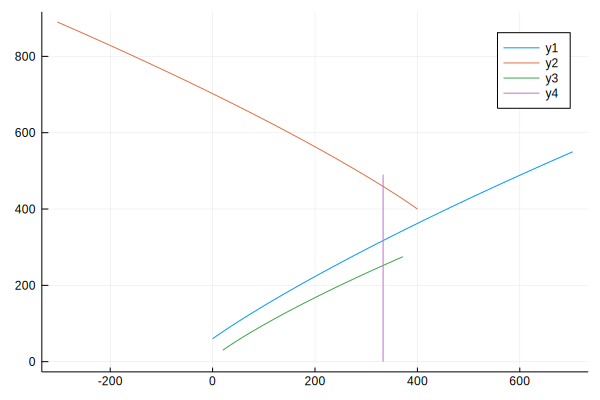

In [25]:
plot(measurementsTrue[1,1,:],measurementsTrue[2,1,:])
plot!(measurementsTrue[1,2,:],measurementsTrue[2,2,:])
plot!(measurementsTrue[1,3,:],measurementsTrue[2,3,:])
plot!(measurementsTrue[1,4,:],measurementsTrue[2,4,:])

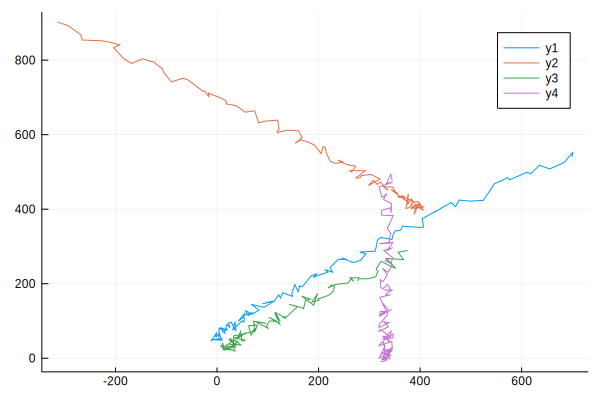

In [26]:
plot(measurementsNoise[1,1,:],measurementsNoise[2,1,:])
plot!(measurementsNoise[1,2,:],measurementsNoise[2,2,:])
plot!(measurementsNoise[1,3,:],measurementsNoise[2,3,:])
plot!(measurementsNoise[1,4,:],measurementsNoise[2,4,:])

In [27]:
file = open("data/measurements.hpp","w+")
print(size(measurementsNoise))
write(file, "float measurements[100][16] = {")
write(file, replace(replace(replace(replace(string(permutedims(measurementsNoise,(2,1,3))) , "[" => "{"),"]"=>"},")," "=>", "),";,"=>",")[1:end-1])  
write(file, "};\n")

close(file)

(4, 4, 100)

Kalman Filter Functions

In [28]:
using LinearAlgebra
function predict(A,X,B,U,P,Q)
    Xp = A*X + B.*U
    Pp = A *P*transpose(A) + Q
    return Xp,Pp
end

function update(P,H,R,Xp,Y)
    Ht = transpose(H)
    K= (P*Ht)/(H*P*Ht+R)
    Xk = Xp + K* (Y-H*Xp)
    Pk = (I - K*H)*P
    return Xk,Pk,K
end 

update (generic function with 1 method)

Runs the Kalman Filter on kinematic data. State transition models based off kinematic equations. 
Non diagonal Covariance terms not used for simplicity.

In [29]:
function runKalmanKinematic(measurements,dt,ax1,ay1,ax2,ay2,ax3,ay3,ax4,ay4,noise,vnoise)
    #Set up initial state
    X = measurements[:,:,1]
    xpred = [X]
    kalmanGains = []
    
    #State transisition matrix, adds dt*velocity to position
    A = [1 0 dt 0; 0 1 0 dt; 0 0 1 0; 0 0 0 1]
    
    #Control matrix, updates position and velocity based on acceleration
    B = [.5*dt^2;.5*dt^2;dt;dt] 
    U = [ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4;ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4]
    H = I
    R = [noise^2 0 0 0;
         0 noise^2 0 0;
         0 0 vnoise^2 0;
         0 0 0 vnoise^2]
    Q = I 
    P = Q
    for i in 2:(size(measurements)[3])
        Xp, Pp = predict(A,X,B,U,P,Q)
        Xk, Pk, K = update(Pp,H,R,Xp,measurements[:,:,i])
        append!(xpred,[Xk])
        append!(kalmanGains,[diag(K)])
        P = Pk
        X = Xk
    end
    return cat(xpred...,dims=3),hcat(kalmanGains...)
end

runKalmanKinematic (generic function with 1 method)

Kalman Filter is run on measurements, green line is filtered value and blue line is the true value

[0.01171303074670571 0.0 0.3294289897510981 0.0; 0.0 0.01171303074670571 0.0 0.3294289897510981; 0.0014641288433382132 0.0 0.6661786237188874 0.0; 0.0 0.0014641288433382132 0.0 0.6661786237188874]
[0.019986557628784856 0.0 0.3659577928678892 0.0; 0.0 0.019986557628784856 0.0 0.3659577928678892; 0.0016264790794128406 0.0 0.624323994632619 0.0; 0.0 0.0016264790794128406 0.0 0.624323994632619]
[0.027991825768987184 0.0 0.3667847393123967 0.0; 0.0 0.027991825768987184 0.0 0.3667847393123967; 0.0016301543969439853 0.0 0.6183343541961083 0.0; 0.0 0.0016301543969439853 0.0 0.6183343541961083]
[0.03549144797661721 0.0 0.36288558370239016 0.0; 0.0 0.03549144797661721 0.0 0.36288558370239016; 0.0016128248164550669 0.0 0.617470999104434 0.0; 0.0 0.0016128248164550669 0.0 0.617470999104434]
[0.042396844794885966 0.0 0.35866397650370363 0.0; 0.0 0.042396844794885966 0.0 0.35866397650370363; 0.0015940621177942384 0.0 0.6173547864968641 0.0; 0.0 0.0015940621177942384 0.0 0.6173547864968641]
[0.048666

[0.08848277870876063 0.0 0.3299069694538449 0.0; 0.0 0.08848277870876063 0.0 0.3299069694538449; 0.0014662531975726443 0.0 0.6174126261233257 0.0; 0.0 0.0014662531975726443 0.0 0.6174126261233257]
[0.088489402591273 0.0 0.32990283682571925 0.0; 0.0 0.088489402591273 0.0 0.32990283682571925; 0.0014662348303365294 0.0 0.6174126375826108 0.0; 0.0 0.0014662348303365294 0.0 0.6174126375826108]
[0.08849488656418956 0.0 0.3298994153850951 0.0; 0.0 0.08849488656418956 0.0 0.3298994153850951; 0.0014662196239337562 0.0 0.6174126470698574 0.0; 0.0 0.0014662196239337562 0.0 0.6174126470698574]
[0.08849942674555905 0.0 0.3298965827742828 0.0; 0.0 0.08849942674555905 0.0 0.3298965827742828; 0.0014662070345523687 0.0 0.6174126549243493 0.0; 0.0 0.0014662070345523687 0.0 0.6174126549243493]
[0.08850318552762601 0.0 0.3298942376770595 0.0; 0.0 0.08850318552762601 0.0 0.3298942376770595; 0.001466196611898041 0.0 0.6174126614270243 0.0; 0.0 0.001466196611898041 0.0 0.6174126614270243]
[0.0885062973716039

[0.08852125017276509 0.0 0.32988296717815707 0.0; 0.0 0.08852125017276509 0.0 0.32988296717815707; 0.001466146520791809 0.0 0.6174126926787734 0.0; 0.0 0.001466146520791809 0.0 0.6174126926787734]
[0.08852125254621555 0.0 0.3298829656973655 0.0; 0.0 0.08852125254621555 0.0 0.3298829656973655; 0.0014661465142105136 0.0 0.6174126926828793 0.0; 0.0 0.0014661465142105136 0.0 0.6174126926828793]
[0.08852125451109134 0.0 0.32988296447148324 0.0; 0.0 0.08852125451109134 0.0 0.32988296447148324; 0.0014661465087621478 0.0 0.6174126926862785 0.0; 0.0 0.0014661465087621478 0.0 0.6174126926862785]
[0.08852125613772598 0.0 0.3298829634566289 0.0; 0.0 0.08852125613772598 0.0 0.3298829634566289; 0.0014661465042516836 0.0 0.6174126926890928 0.0; 0.0 0.0014661465042516836 0.0 0.6174126926890928]
[0.08852125748434557 0.0 0.3298829626164753 0.0; 0.0 0.08852125748434557 0.0 0.3298829626164753; 0.0014661465005176674 0.0 0.6174126926914224 0.0; 0.0 0.0014661465005176674 0.0 0.6174126926914224]
[0.0885212585

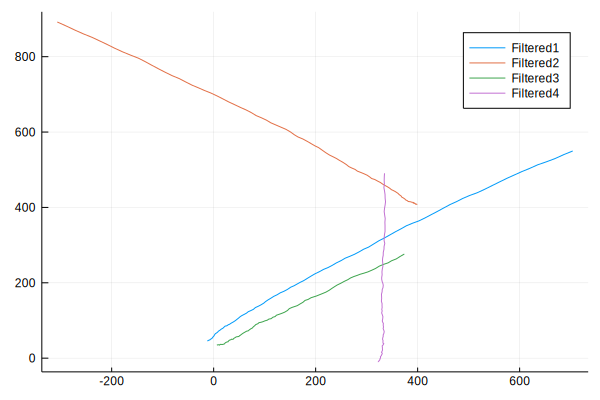

In [30]:
xf,kGains = runKalmanKinematic(measurementsNoise,dt,.1,.1,-.1,.1,.05,.05,0,.1,noise/2,vnoise/2)
plot(xf[1,1,:],xf[2,1,:],label="Filtered1")
plot!(xf[1,2,:],xf[2,2,:],label="Filtered2")
plot!(xf[1,3,:],xf[2,3,:],label="Filtered3")
plot!(xf[1,4,:],xf[2,4,:],label="Filtered4")

RMSE error of filtered values. X, Y, Vx, Vy in order

In [31]:
sqrt.(sum((xf - (measurementsTrue)).^2,dims=3)/100)

4×4×1 Array{Float64,3}:
[:, :, 1] =
 3.91011   2.45693   4.33423   3.75758 
 4.7578    3.04231   2.78025   2.95685 
 0.392292  0.387172  0.352371  0.379323
 0.386582  0.391835  0.365494  0.381572